In [31]:
import argparse
import os

import numpy as np

from sklearn.metrics import mean_absolute_error

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
from torchvision import transforms
from torchvision import models

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.style as style

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from itertools import product, permutations
import copy
import pickle
from PIL import Image


In [32]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

In [33]:
if torch.cuda.is_available():
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
else:
    torch.set_default_tensor_type('torch.FloatTensor')

In [34]:
def filterLabelsByFrequency(artworks, frequency):
  for column in artworks.filter(regex='labels'):
    label_freq = artworks[column].apply(
        lambda s: [x for x in s]).explode().value_counts().sort_values(ascending=False)

    # Create a list of rare labels
    rare = list(label_freq[label_freq < frequency].index)

    artworks[column] = artworks[column].apply(
        lambda s: [x for x in s if x not in rare])
    artworks[column] = artworks[column].apply(
        lambda s: s if len(s) != 0 else np.nan)

  artworks.dropna(inplace=True)
  return artworks

In [35]:
with open("artworks", "rb") as file:
    artworks = pickle.load(file)

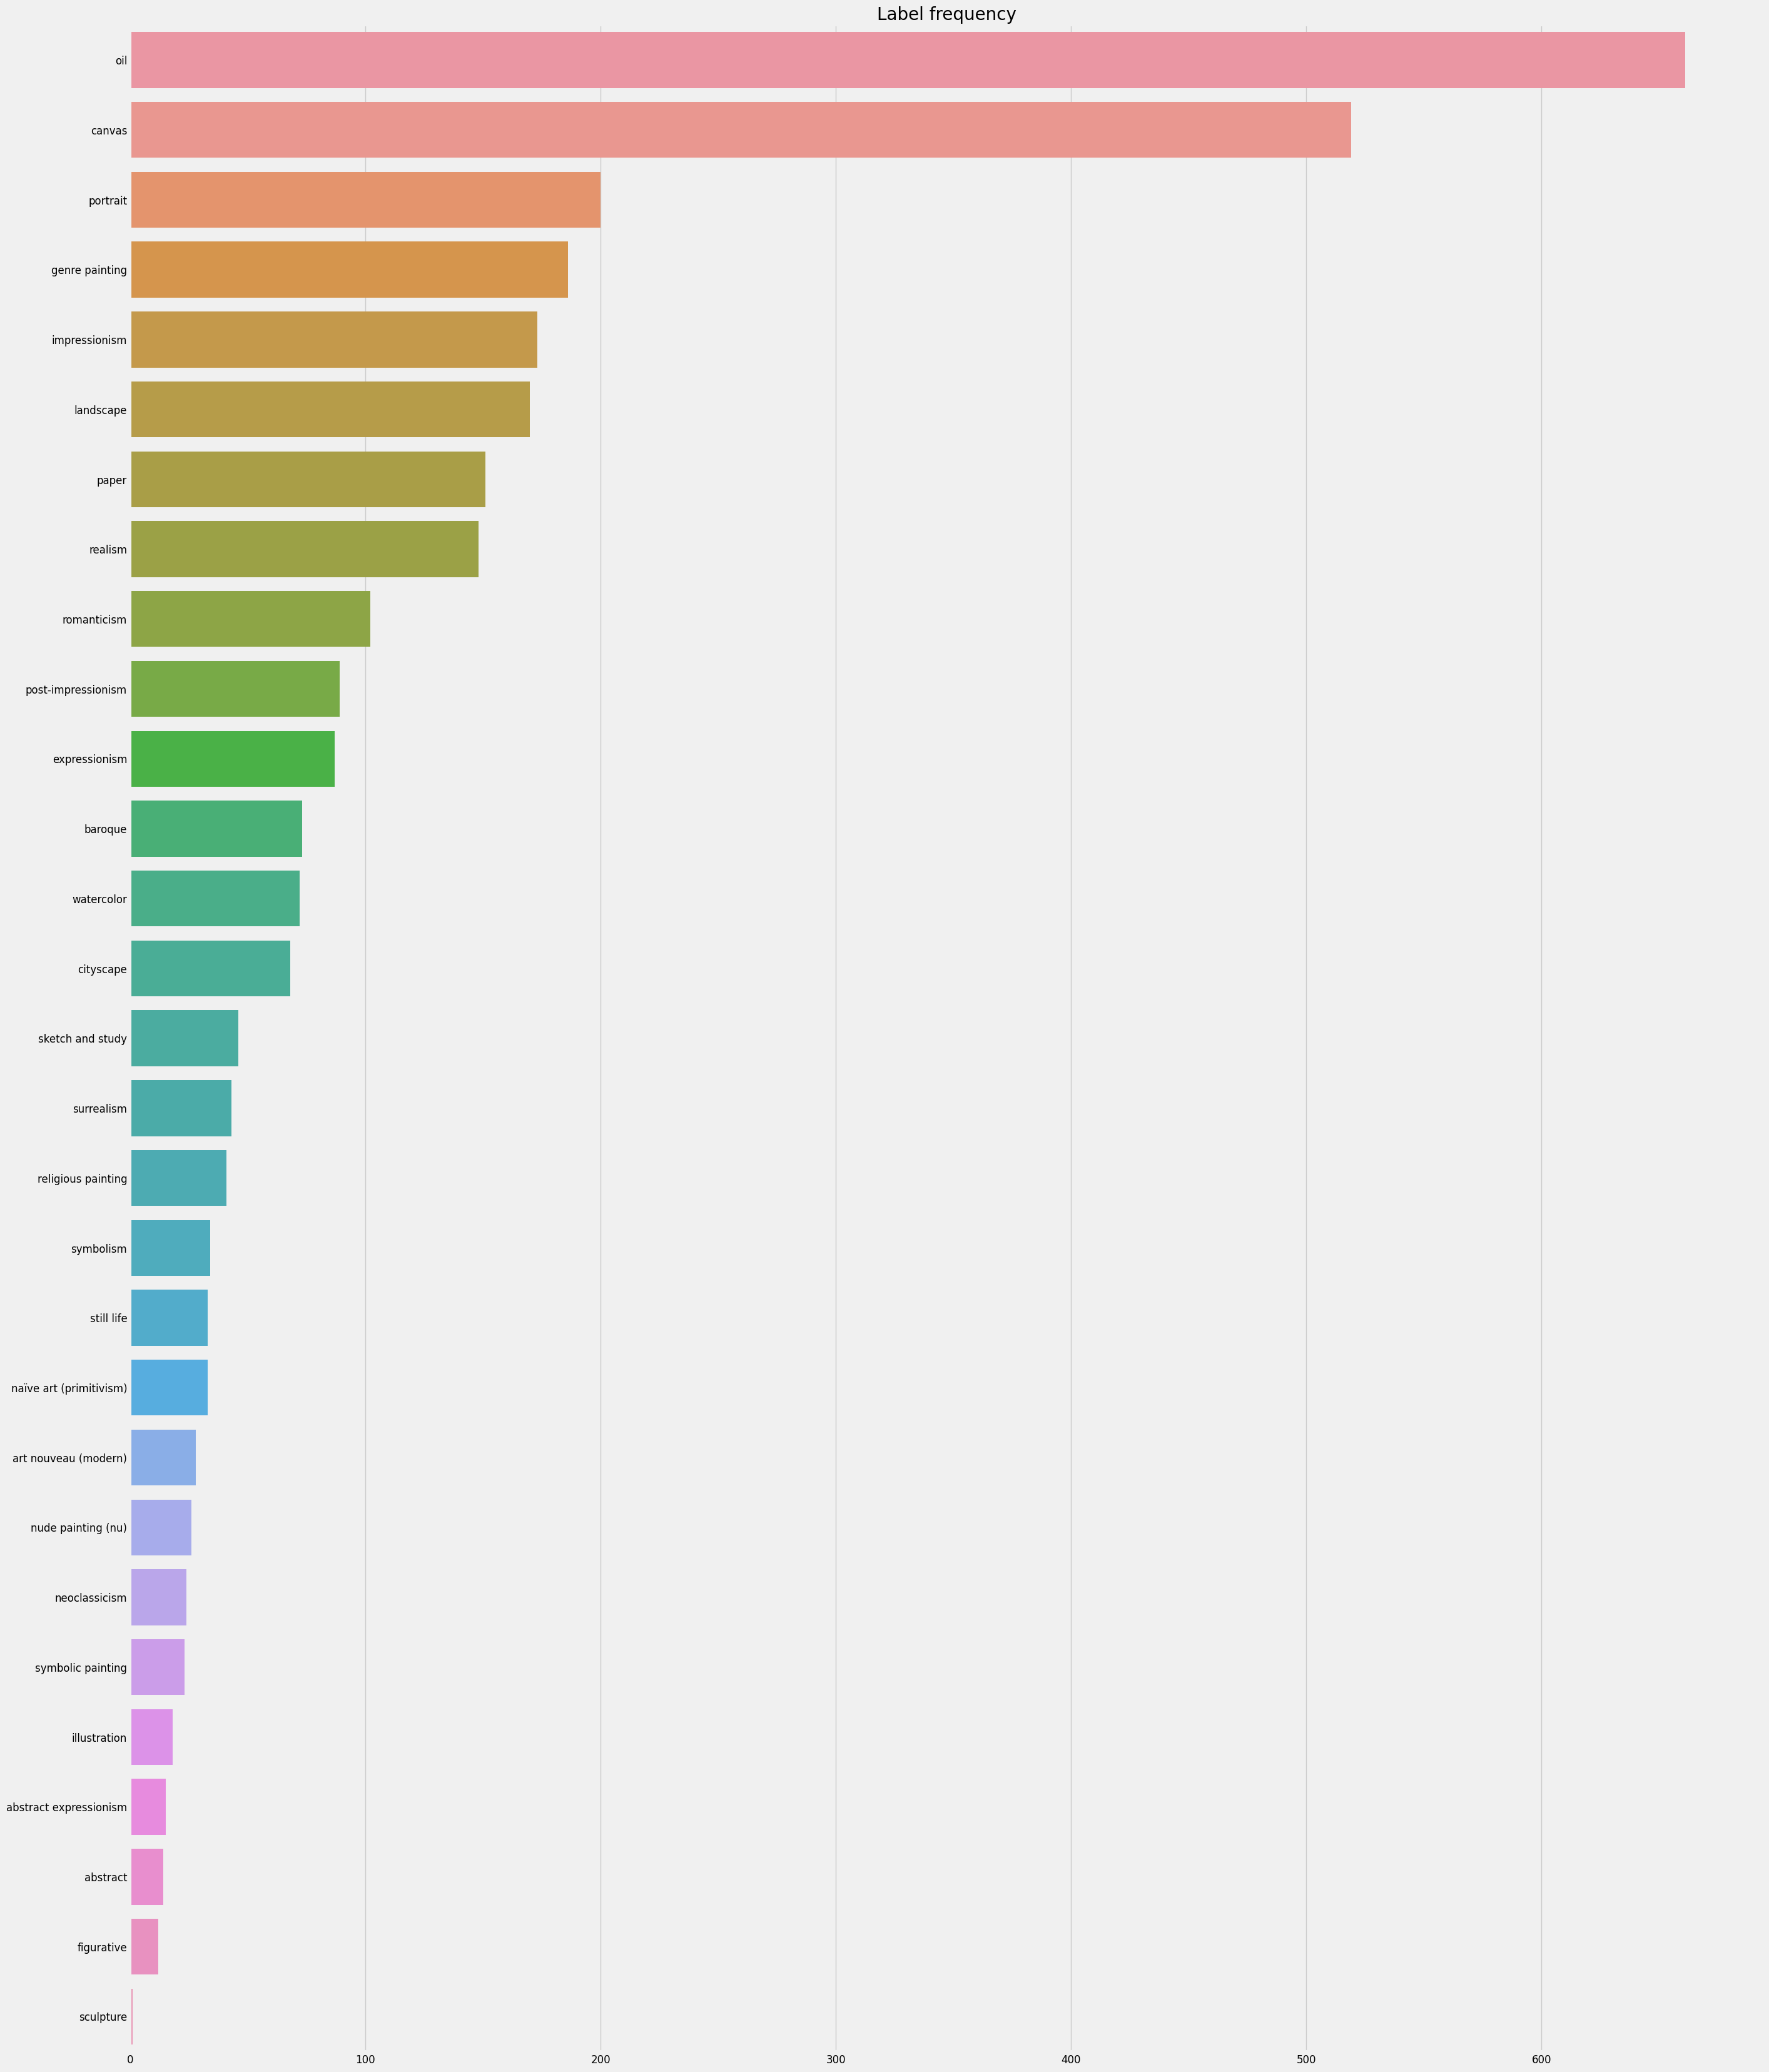

In [36]:
artworks = filterLabelsByFrequency(artworks, 100)

object_label_freq = artworks['object_labels'].apply(
    lambda s: [x for x in s]).explode().value_counts()
style_label_freq = artworks['style_labels'].apply(
    lambda s: [x for x in s]).explode().value_counts()
material_label_freq = artworks['material_labels'].apply(
    lambda s: [x for x in s]).explode().value_counts()

label_freq = pd.concat([object_label_freq, style_label_freq,
                       material_label_freq]).sort_values(ascending=False)

style.use("fivethirtyeight")
plt.figure(figsize=(30, 40))
sns.barplot(y=label_freq.index.values, x=label_freq, order=label_freq.index)
plt.title("Label frequency", fontsize=20)
plt.xlabel("")
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In [37]:
def count_labels(label_list):
    total_labels = []
    for labels in label_list:
      labels = list(filter(None, labels))
      total_labels.extend(labels)

    return len(list(set(total_labels))), list(set(total_labels))


def get_index_of_np(numpy, val):
  index_np = np.where(numpy == val)[0]

  if index_np.size != 1:
    print('a', index_np[0], index_np.size, val)
    return None
  else:
    return index_np[0]

In [38]:
def get_adjacency_matrix(artwork_labels_list, total_labels, N_LABEL):
  adjacency_matrix = np.zeros((N_LABEL, N_LABEL))

  for artwork_labels in artwork_labels_list:
    label_combinations = list(product(artwork_labels, repeat=2))

    for label_combination in label_combinations:
      pivot_index = get_index_of_np(total_labels, label_combination[0])
      target_index = get_index_of_np(total_labels, label_combination[1])
      if (pivot_index is None) or (target_index is None):
        return None
      else:
        adjacency_matrix[pivot_index][target_index] += 1

  for row_index, row in enumerate(adjacency_matrix):
    basis = row[row_index]
    for col_index, val in enumerate(row):
      row[col_index] = val/basis

  return adjacency_matrix

In [39]:
def convert_to_graph(artworks):
  label_classes = ['object_labels', 'style_labels', 'material_labels']
  artwork_labels_list = []
  labels_list_by_class = [set() for _ in range(3)]

  for index, label_class in enumerate(label_classes):
    labels_group = artworks[label_class]

    if index == 0:
      for labels in labels_group:
        artwork_labels_list.append(copy.deepcopy(labels))
        labels_list_by_class[index] = labels_list_by_class[index].union(
            set(copy.deepcopy(labels)))
    else:
      for i, labels in enumerate(labels_group):
        artwork_labels_list[i].extend(copy.deepcopy(labels))
        labels_list_by_class[index] = labels_list_by_class[index].union(
            set(copy.deepcopy(labels)))

  N_LABEL, total_labels = count_labels(artwork_labels_list)
  adjacency_matrix = get_adjacency_matrix(
      artwork_labels_list, np.array(total_labels), N_LABEL)

  class_one_hot_encoding_matrix = np.zeros((N_LABEL, 3))

  for i in range(N_LABEL):
    label = total_labels[i]
    for j in range(3):
      class_one_hot_encoding_matrix[i][j] = np.any(
          np.array(list(labels_list_by_class[j])) == label)

  embedding = nn.Embedding(N_LABEL, embedding_dim=5)
  input = torch.tensor(range(len(total_labels)))
  word_embedding_matrix = embedding(input).detach().cpu().numpy()

  feature_matrix = np.concatenate(
      (class_one_hot_encoding_matrix, word_embedding_matrix), axis=1)

  return adjacency_matrix, feature_matrix, N_LABEL, total_labels


In [40]:
adjacency_matrix, feature_matrix, N_LABEL, total_labels = convert_to_graph(
    artworks)

In [41]:
feature_matrix_tensor = torch.Tensor(
    feature_matrix).to(torch.float32).to(device)
adjacency_matrix_tensor = torch.Tensor(
    adjacency_matrix).to(torch.float32).to(device)

In [42]:
degree_matrix_tensor = torch.diag(torch.sum(adjacency_matrix_tensor, dim=1))
laplacian_matrix_tensor = degree_matrix_tensor - adjacency_matrix_tensor

In [43]:
root_path = './database_all'

In [44]:
artworks['labels'] = artworks['object_labels'] + \
    artworks['style_labels'] + artworks['material_labels']

dataset_size = len(artworks)
train_size = int(dataset_size * 0.8)
validation_size = int(dataset_size * 0.2)
test_size = int(validation_size * 0.5)

X_train, X_val, y_train, y_val = train_test_split(
    artworks['File'], artworks['labels'], test_size=0.2, random_state=23)
X_val, X_test, y_val, y_test = train_test_split(
    X_val, y_val, test_size=0.5, random_state=23)

X_train = [os.path.join(root_path, str(f)) for f in X_train]
X_val = [os.path.join(root_path, str(f)) for f in X_val]
X_test = [os.path.join(root_path, str(f)) for f in X_test]

label_list = pd.DataFrame({'labels': [total_labels]})
mlb = MultiLabelBinarizer(classes=total_labels)
mlb.fit(label_list['labels'])

y_train = list(y_train)
y_val = list(y_val)
y_test = list(y_test)
y_train_bin = mlb.transform(y_train).astype(np.float64)
y_val_bin = mlb.transform(y_val).astype(np.float64)
y_test_bin = mlb.transform(y_test).astype(np.float64)

In [45]:
class ArtworksDataset(Dataset):
    def __init__(self, X, y, transform=None):
        self.X = X
        self.y = y
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        img = Image.open(self.X[index]).convert('RGB')
        label = torch.tensor(self.y[index], dtype=torch.float32)

        if self.transform:
            img = self.transform(img)

        return img, label

In [46]:
def get_dataloader(X, y, batch_size, mode='train', shuffle=True, random_seed=42):
    # if shuffle:
    #     torch.manual_seed(random_seed)
        
    if mode == 'train':
        transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
        ])
    else:
        transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
        ])

    dataset = ArtworksDataset(X, y, transform=transform)
    dataloader = DataLoader(dataset, batch_size=batch_size,
                            shuffle=shuffle, generator=torch.Generator(device=device))
    total_batch = dataset.__len__() // batch_size
    return dataloader, total_batch

In [47]:
class AttentionModule(nn.Module):
  def __init__(self, in_dim, out_dim, head_num=2):
    super(AttentionModule, self).__init__()

    self.head_num = head_num
    self.attention_dim = out_dim // head_num

    self.linears = nn.ModuleList()
    self.correlations = nn.ParameterList()
    for i in range(self.head_num):
      self.linears.append(nn.Linear(in_dim, self.attention_dim))
      correlation = torch.FloatTensor(
          self.attention_dim, self.attention_dim).to(device)
      nn.init.xavier_uniform_(correlation)
      self.correlations.append(nn.Parameter(correlation))

    self.tanh = nn.Tanh()
    self.set_out_dim = nn.Linear(head_num * self.attention_dim, out_dim)

  def forward(self, x, adj):
    heads = list()
    for i in range(self.head_num):
      x_i = self.linears[i](x)
      alpha = self.attention_matrix(x_i, self.correlations[i], adj)
      x_head = torch.matmul(alpha, x_i)
      heads.append(x_head)
    out = torch.cat(heads, dim=2)
    out = self.set_out_dim(out)
    return out

  def attention_matrix(self, x_i, correlation, adj):
    x = torch.matmul(x_i, correlation)
    alpha = torch.matmul(x, torch.transpose(x_i, 1, 2))
    alpha = torch.mul(alpha, adj)
    alpha = self.tanh(alpha)
    return alpha

In [48]:
class GCNLayer(nn.Module):
	def __init__(self, in_dim, out_dim, act=None, atn=False, head_num=2, drop_rate=0):
		super(GCNLayer, self).__init__()

		self.linear = nn.Linear(in_dim, out_dim)
		nn.init.xavier_uniform_(self.linear.weight)
		self.activation = act
		self.use_attention = atn
		self.attention = AttentionModule(out_dim, out_dim, head_num)
		# self.drop_rate = drop_rate
		# self.dropout = nn.Dropout(self.drop_rate)

	def forward(self, x, adj):
		out = self.linear(x)
		if self.use_attention:
			out = self.attention(out, adj)
		out = torch.matmul(adj, out)
		if self.activation != None:
			out = self.activation(out)
		# if self.drop_rate > 0:
		# 	out = self.dropout(out)
		return out, adj

In [49]:
class GatedSkipConnection(nn.Module):
  def __init__(self, in_dim, out_dim):
    super(GatedSkipConnection, self).__init__()

    self.in_dim = in_dim
    self.out_dim = out_dim

    self.linear = nn.Linear(in_dim, out_dim, bias=False)
    self.linear_coef_in = nn.Linear(out_dim, out_dim)
    self.linear_coef_out = nn.Linear(out_dim, out_dim)
    self.sigmoid = nn.Sigmoid()

  def forward(self, in_x, out_x):
    if (self.in_dim != self.out_dim):
        in_x = self.linear(in_x)
    z = self.gate_coefficient(in_x, out_x)
    out = torch.mul(z, out_x) + torch.mul(1.0-z, in_x)
    return out

  def gate_coefficient(self, in_x, out_x):
    x1 = self.linear_coef_in(in_x)
    x2 = self.linear_coef_out(out_x)
    return self.sigmoid(x1+x2)

In [50]:
class GCNBlock(nn.Module):
  def __init__(self, n_layer, in_dim, hidden_dim, out_dim, sc='gsc', act=None, atn=True, head_num=2, drop_rate=0):
    super(GCNBlock, self).__init__()

    self.layers = nn.ModuleList()
    for i in range(n_layer):
        self.layers.append(GCNLayer(in_dim if i == 0 else hidden_dim,
                                    out_dim if i == n_layer-1 else hidden_dim,
                                    act,
                                    False if i == n_layer-1 else atn,
                                    1 if i == n_layer-1 else head_num,
                                    drop_rate))
    if sc == 'gsc':
        self.sc = GatedSkipConnection(in_dim, out_dim)
    elif sc == 'no':
        self.sc = None
    else:
        assert False, "Wrong sc type."

  def forward(self, x, adj):
    residual = x
    out = None
    for i, layer in enumerate(self.layers):
        out, adj = layer((x if i == 0 else out), adj)
    if self.sc != None:
        out = self.sc(residual, out)
    return out, adj

In [51]:
class InceptionModule(nn.Module):
  def __init__(self, n_layer, in_dim, hidden_dim, out_dim, sc='gsc', act=None, atn=True, head_num=2, drop_rate=0):
    super(InceptionModule, self).__init__()
    self.GCNBlocks = nn.ModuleList()
    for i in range(n_layer):
      self.GCNBlocks.append(GCNBlock(i + 1,
                                     in_dim,
                                     hidden_dim,
                                     out_dim,
                                     sc,
                                     act,
                                     atn,
                                     head_num,
                                     drop_rate))

  def forward(self, x, lapl):
    outs = []
    for i, block in enumerate(self.GCNBlocks):
      out, _ = block(x, lapl)
      outs.append(out)

    feature_concatenate = torch.cat(outs, 2)
    return feature_concatenate, lapl

In [52]:
class ReadOut(nn.Module):

    def __init__(self, in_dim, out_dim, act=None):
        super(ReadOut, self).__init__()

        self.in_dim = in_dim
        self.out_dim = out_dim

        self.linear = nn.Linear(self.in_dim,
                                self.out_dim)
        nn.init.xavier_uniform_(self.linear.weight)
        self.activation = act

    def forward(self, x):
        out = self.linear(x)
        if self.activation != None:
            out = self.activation(out)
        out = torch.squeeze(out)
        return out

In [53]:
class GCNNet(nn.Module):
  def __init__(self, args, lapl_matrix):
    super(GCNNet, self).__init__()

    self.InceptionModule = InceptionModule(args.n_layer,
                                           args.in_dim,
                                           args.hidden_dim,
                                           args.out_dim,
                                           args.sc,
                                           args.act,
                                           args.atn,
                                           args.head_num,
                                           args.drop_rate)
    self.Readout = ReadOut(args.out_dim * args.n_layer,
                           1, None)
    self.lapl_matrix = lapl_matrix

  def forward(self, x):
    out, _ = self.InceptionModule(x, self.lapl_matrix)
    out = self.Readout(out)

    return out

In [54]:
# Define the model architecture
class Resnet50(nn.Module):
    def __init__(self, n_label):
        super(Resnet50, self).__init__()
        self.resnet = models.resnet50(pretrained=True)
        num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(num_ftrs, n_label)
        )

    def forward(self, x):
        x = self.resnet(x)
        return x

In [55]:
# class CNNGCN_new(nn.Module):
# 	def __init__(self, args, lapl_matrix):
# 		super(CNNGCN_new, self).__init__()
# 		self.cnn = Resnet50(args.n_label)
# 		self.gcn = GCNNet_new(args, lapl_matrix)

# 	def forward(self, x):
# 		cnn_out = self.cnn(x)
# 		cnn_out_2d = torch.transpose(torch.unsqueeze(cnn_out, 1), 1, 2)
# 		gcn_out = self.gcn(cnn_out_2d)
# 		return gcn_out

In [56]:
def multi_label_metrics(y_true, y_pred):
    """
    다중 레이블 분류 문제에서 Precision, recall, F1 score 계산 함수
    
    Args:
        y_true (torch.Tensor): 정답 레이블. shape: (batch_size, num_classes)
        y_pred (torch.Tensor): 모델 예측 레이블. shape: (batch_size, num_classes)
        
    Returns:
        precision (float): Precision 값
        recall (float): Recall 값
        f1_score (float): F1 Score 값
    """
    true_positives = torch.sum((y_true == 1) & (y_pred == 1), dim=0)
    false_positives = torch.sum((y_true == 0) & (y_pred == 1), dim=0)
    false_negatives = torch.sum((y_true == 1) & (y_pred == 0), dim=0)

    precision = torch.mean(
        true_positives / (true_positives + false_positives + 1e-8))
    recall = torch.mean(
        true_positives / (true_positives + false_negatives + 1e-8))
    f1_score = 2 * ((precision * recall) / (precision + recall + 1e-8))

    return precision.item(), recall.item(), f1_score.item()

In [57]:
def train_cnngcn(model, criterion, optimizer, batch_size, scheduler, num_epochs):
    train_loader, train_total_batch = get_dataloader(
        X_train, y_train_bin, batch_size, 'train')
    val_loader, val_total_batch = get_dataloader(
        X_val, y_val_bin, batch_size, 'val')

    train_precision_list = []
    train_recall_list = []
    train_f1_list = []
    train_loss_list = []
    val_precision_list = []
    val_recall_list = []
    val_f1_list = []
    val_loss_list = []
    best_val_precision = 0.0
    patience = 0  # early stopping 관련 변수

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        total_predictions = []
        total_labels = []

        for inputs, labels in train_loader:
            inputs = inputs.to(torch.float32).to(device)
            labels = labels.to(device)

            # 모델에 입력값 전달
            outputs = model(inputs)

            # 손실 계산
            loss = criterion(outputs, labels)

            # 기울기 초기화, 역전파, optimizer 업데이트
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # 예측값 계산
            predictions = torch.sigmoid(outputs) >= 0.5

            # 손실계산
            running_loss += loss.item() * inputs.size(0)
            total_predictions += predictions.tolist()
            total_labels += labels.tolist()

        scheduler.step()

        # 에폭별 손실과 정확도
        epoch_loss = running_loss / len(train_loader.dataset)
        train_precision, train_recall, train_f1_score = multi_label_metrics(
            torch.tensor(total_labels), torch.tensor(total_predictions))

        train_precision_list.append(train_precision)
        train_recall_list.append(train_recall)
        train_f1_list.append(train_f1_score)
        train_loss_list.append(epoch_loss)

        # validation set에서 모델 평가
        model.eval()
        val_running_loss = 0.0
        val_total_predictions = []
        val_total_labels = []

        for val_inputs, val_labels in val_loader:
            val_inputs = val_inputs.to(torch.float32).to(device)
            val_labels = val_labels.to(device)

            # 모델에 입력값 전달
            val_outputs = model(val_inputs)

            # 손실 계산
            val_loss = criterion(val_outputs, val_labels)

            # 예측값 계산
            val_prediction = torch.sigmoid(val_outputs) >= 0.5

            # 정확도 계산
            val_running_loss += val_loss.item() * val_inputs.size(0)
            val_total_predictions += val_prediction.tolist()
            val_total_labels += val_labels.tolist()

        # 에폭별 손실과 정확도
        val_epoch_loss = val_running_loss / len(val_loader.dataset)
        val_precision, val_recall, val_f1_score = multi_label_metrics(
            torch.tensor(val_total_labels), torch.tensor(val_total_predictions))

        val_precision_list.append(val_precision)
        val_recall_list.append(val_recall)
        val_f1_list.append(val_f1_score)
        val_loss_list.append(val_epoch_loss)

        print('Epoch [{}/{}], train_loss: {:.4f}, train_precision: {:.4f}, train_recall: {:.4f}, train_f1_score: {:.4f}\nval_loss: {:.4f}, val_precision: {:.4f}, val_recall: {:.4f}, val_f1_score: {:.4f}'
              .format(epoch+1, num_epochs, epoch_loss, train_precision, train_recall, train_f1_score, val_epoch_loss, val_precision, val_recall, val_f1_score))

        # early stopping 적용
        if val_precision > best_val_precision:
            best_val_precision = val_precision
            patience = 0
            print('patience: {}'.format(patience))
        else:
            if patience > 5:
                break
            patience += 1
            
    return model, train_loss_list, train_precision_list, train_recall_list, train_f1_list, val_loss_list, val_precision_list, val_recall_list, val_f1_list


In [58]:
class CNNGCN_2(nn.Module):
	def __init__(self, num_classes, adj_matrix, args):
		super(CNNGCN_2, self).__init__()
		self.cnn = Resnet50(num_classes)
		self.adj_matrix = adj_matrix
		self.gcnnet = GCNNet(args, self.adj_matrix)
	def forward(self, x):
		cnn_out = self.cnn(x)
		cnn_out_2 = torch.transpose(torch.unsqueeze(cnn_out, 1), 1, 2)
		gcn_out = self.gcnnet(cnn_out_2)
		return gcn_out

In [59]:
paser = argparse.ArgumentParser()
args = paser.parse_args("")
args.n_layer = 3
args.in_dim = 1
args.hidden_dim = 5
args.out_dim = 1
args.sc = 'gsc'
args.act = nn.ELU()
args.atn = False
args.head_num = 2
args.drop_rate = 0

model_cnngcn = CNNGCN_2(N_LABEL, laplacian_matrix_tensor, args).to(device)

optimizer_ft = optim.Adam(model_cnngcn.parameters(), lr=0.001)
exp_lr_scheduler = optim.lr_scheduler.StepLR(
    optimizer_ft, step_size=7, gamma=0.1)
criterion = nn.MultiLabelSoftMarginLoss()

# Train the model
model_cnngcn, train_loss, train_precision, train_recall, train_f1, val_loss, val_precision, val_recall, val_f1 = train_cnngcn(
    model_cnngcn, criterion, optimizer_ft, 16, exp_lr_scheduler, 30)


C:\Users\이성준\AppData\Roaming\Python\Python310\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\이성준\AppData\Roaming\Python\Python310\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/30], train_loss: 0.3524, train_precision: 0.1380, train_recall: 0.1259, train_f1_score: 0.1317
val_loss: 0.3336, val_precision: 0.1182, val_recall: 0.1210, val_f1_score: 0.1196
patience: 0
Epoch [2/30], train_loss: 0.2870, train_precision: 0.1506, train_recall: 0.1257, train_f1_score: 0.1370
val_loss: 0.2704, val_precision: 0.1176, val_recall: 0.0978, val_f1_score: 0.1068
Epoch [3/30], train_loss: 0.2721, train_precision: 0.1969, train_recall: 0.1309, train_f1_score: 0.1572
val_loss: 0.2587, val_precision: 0.1103, val_recall: 0.1060, val_f1_score: 0.1081
Epoch [4/30], train_loss: 0.2584, train_precision: 0.1685, train_recall: 0.1260, train_f1_score: 0.1442
val_loss: 0.2391, val_precision: 0.1447, val_recall: 0.1226, val_f1_score: 0.1327
patience: 0
Epoch [5/30], train_loss: 0.2452, train_precision: 0.2736, train_recall: 0.1460, train_f1_score: 0.1904
val_loss: 0.2376, val_precision: 0.1405, val_recall: 0.1387, val_f1_score: 0.1396
Epoch [6/30], train_loss: 0.2347, train_precis

In [ ]:
paser = argparse.ArgumentParser()
args = paser.parse_args("")
args.n_layer = 3
args.in_dim = 1
args.hidden_dim = 5
args.out_dim = 1
args.sc = 'gsc'
args.act = nn.ELU()
args.atn = False
args.head_num = 2
args.drop_rate = 0

model_cnngcn_epoch13 = CNNGCN_2(
    N_LABEL, adjacency_matrix_tensor, args).to(device)
model_cnngcn_epoch13.load_state_dict(
    torch.load('./models/cnngnn-epoch50_3_1_5_1_gsc_elu_false_2_0-earlystopping-precision10.pt'))

optimizer_ft = optim.Adam(model_cnngcn_epoch13.parameters(), lr=0.001)
exp_lr_scheduler = optim.lr_scheduler.StepLR(
    optimizer_ft, step_size=7, gamma=0.1)
criterion = nn.MultiLabelSoftMarginLoss()

model_cnngcn_epoch13, train_loss, train_precision, train_recall, train_f1, val_loss, val_precision, val_recall, val_f1 = train_cnngcn(
    model_cnngcn_epoch13, criterion, optimizer_ft, 16, exp_lr_scheduler, 100)


In [31]:
model_path = './models/'
torch.save(model_cnngcn.state_dict(), model_path +
           'cnngnn-epoch30_3_1_5_1_gsc_elu_false_2_0.pt')

with open("cnngcn_train_loss-epoch30.pickle", "wb") as f:
    pickle.dump(train_loss, f)
with open("cnngcn_train_precision-epoch30.pickle", "wb") as f:
    pickle.dump(train_precision, f)
with open("cnngcn_train_recall-epoch30.pickle", "wb") as f:
    pickle.dump(train_recall, f)
with open("cnngcn_train_f1s-epoch30.pickle", "wb") as f:
    pickle.dump(train_f1, f)

with open("cnngcn_val_loss-epoch30.pickle", "wb") as f:
    pickle.dump(val_loss, f)
with open("cnngcn_val_precision-epoch30.pickle", "wb") as f:
    pickle.dump(val_precision, f)
with open("cnngcn_val_recall-epoch30.pickle", "wb") as f:
    pickle.dump(val_recall, f)
with open("cnngcn_val_f1s-epoch30.pickle", "wb") as f:
    pickle.dump(val_f1, f)


In [30]:
def train(model, criterion, optimizer, batch_size, scheduler, num_epochs):
    train_loader, train_total_batch = get_dataloader(
        X_train, y_train_bin, batch_size, 'train')
    val_loader, val_total_batch = get_dataloader(
        X_val, y_val_bin, batch_size, 'val')

    train_precision_list = []
    train_recall_list = []
    train_f1_list = []
    train_loss_list = []
    val_precision_list = []
    val_recall_list = []
    val_f1_list = []
    val_loss_list = []
    best_val_loss = float('inf')
    patience = 0  # early stopping 관련 변수

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        total_predictions = []
        total_labels = []

        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # 모델에 입력값 전달
            outputs = model(inputs)

            # 손실 계산
            loss = criterion(outputs, labels)

            # 기울기 초기화, 역전파, optimizer 업데이트
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # 예측값 계산
            predictions = torch.sigmoid(outputs) >= 0.5

            # 손실계산
            running_loss += loss.item() * inputs.size(0)
            total_predictions += predictions.tolist()
            total_labels += labels.tolist()

        scheduler.step()

        # 에폭별 손실과 정확도
        epoch_loss = running_loss / len(train_loader.dataset)
        train_precision, train_recall, train_f1_score = multi_label_metrics(
            torch.tensor(total_labels), torch.tensor(total_predictions))

        train_precision_list.append(train_precision)
        train_recall_list.append(train_recall)
        train_f1_list.append(train_f1_score)
        train_loss_list.append(epoch_loss)

        # validation set에서 모델 평가
        model.eval()
        val_running_loss = 0.0
        val_total_predictions = []
        val_total_labels = []

        for val_inputs, val_labels in val_loader:
            val_inputs = val_inputs.to(device)
            val_labels = val_labels.to(device)

            # 모델에 입력값 전달
            val_outputs = model(val_inputs)

            # 손실 계산
            val_loss = criterion(val_outputs, val_labels)

            # 예측값 계산
            val_prediction = torch.sigmoid(val_outputs) >= 0.5

            # 정확도 계산
            val_running_loss += val_loss.item() * val_inputs.size(0)
            val_total_predictions += val_prediction.tolist()
            val_total_labels += val_labels.tolist()

        # 에폭별 손실과 정확도
        val_epoch_loss = val_running_loss / len(val_loader.dataset)
        val_precision, val_recall, val_f1_score = multi_label_metrics(
            torch.tensor(val_total_labels), torch.tensor(val_total_predictions))

        val_precision_list.append(val_precision)
        val_recall_list.append(val_recall)
        val_f1_list.append(val_f1_score)
        val_loss_list.append(val_epoch_loss)

        print('Epoch [{}/{}], train_loss: {:.4f}, train_precision: {:.4f}, train_recall: {:.4f}, train_f1_score: {:.4f}\nval_loss: {:.4f}, val_precision: {:.4f}, val_recall: {:.4f}, val_f1_score: {:.4f}'
              .format(epoch+1, num_epochs, epoch_loss, train_precision, train_recall, train_f1_score, val_epoch_loss, val_precision, val_recall, val_f1_score))

        # early stopping 적용
        # if val_epoch_loss < best_val_loss:
        #     best_val_loss = val_epoch_loss
        #     patience = 0
        # else:
        #     if patience > 5:
        #         break
        #     patience += 1
    return model, train_loss_list, train_precision_list, train_recall_list, train_f1_list, val_loss_list, val_precision_list, val_recall_list, val_f1_list


In [ ]:
# Define the model, optimizer and loss function
model_resnet = Resnet50(N_LABEL).to(device)
optimizer_ft = optim.Adam(model_resnet.parameters(), lr=0.001)
exp_lr_scheduler = optim.lr_scheduler.StepLR(
    optimizer_ft, step_size=7, gamma=0.1)
criterion = nn.MultiLabelSoftMarginLoss()

# Train the model
model_resnet, train_loss_resnet, train_precision_resnet, train_recall_resnet, train_f1_resnet, val_loss_resnet, val_precision_resnet, val_recall_resnet, val_f1_resnet = train(
    model_resnet, criterion, optimizer_ft, 16, exp_lr_scheduler, 50)


In [35]:
model_path = './models/'
torch.save(model_resnet.state_dict(), model_path + 'resnet50-epoch50_test.pt')

with open("resnet50_train_loss-epoch50.pickle", "wb") as f:
    pickle.dump(train_loss_resnet, f)
with open("resnet50_train_precision-epoch50.pickle", "wb") as f:
    pickle.dump(train_precision_resnet, f)
with open("resnet50_train_recall-epoch50.pickle", "wb") as f:
    pickle.dump(train_recall_resnet, f)
with open("resnet50_train_f1s-epoch50.pickle", "wb") as f:
    pickle.dump(train_f1_resnet, f)

with open("resnet50_val_loss-epoch50.pickle", "wb") as f:
    pickle.dump(val_loss_resnet, f)
with open("resnet50_val_precision-epoch50.pickle", "wb") as f:
    pickle.dump(val_precision_resnet, f)
with open("resnet50_val_recall-epoch50.pickle", "wb") as f:
    pickle.dump(val_recall_resnet, f)
with open("resnet50_val_f1s-epoch50.pickle", "wb") as f:
    pickle.dump(val_f1_resnet, f)

In [79]:
criterion = nn.MultiLabelSoftMarginLoss()

test_loader, test_total_batch = get_dataloader(
    X_test, y_test_bin, 16, 'test')

model_cnngcn.eval()
test_running_loss = 0.0
test_total_predictions = []
test_total_labels = []

for test_inputs, test_labels in test_loader:
    test_inputs = test_inputs.to(device)
    test_labels = test_labels.to(device)

    # 모델에 입력값 전달
    test_outputs = model_cnngcn(test_inputs)

    # 손실 계산
    test_loss = criterion(test_outputs, test_labels)

    # 예측값 계산
    test_prediction = torch.sigmoid(test_outputs) >= 0.5

    # 정확도 계산
    test_running_loss += test_loss.item() * test_inputs.size(0)
    test_total_predictions += test_prediction.tolist()
    test_total_labels += test_labels.tolist()

test_epoch_loss = test_running_loss / len(test_loader.dataset)
test_precision, test_recall, test_f1_score = multi_label_metrics(
    torch.tensor(test_total_labels), torch.tensor(test_total_predictions))
print(test_epoch_loss, test_precision, test_recall, test_f1_score)


0.23567164369991847 0.27262166142463684 0.21443380415439606 0.24005191028118134


In [ ]:
class CNNGCN_3(nn.Module):
	def __init__(self, num_classes, adj_matrix):
		super(CNNGCN_3, self).__init__()
		self.cnn = Resnet50(num_classes)
		self.adj_matrix = adj_matrix
		self.gcnblock = GCNBlock(2, 1, 5, 1, 'no', False, 0, 0)

	def forward(self, x):
		cnn_out = self.cnn(x)
		cnn_out_2 = torch.transpose(torch.unsqueeze(cnn_out, 1), 1, 2)
		gcn_out, _ = self.gcnblock(cnn_out_2, self.adj_matrix)
		gcn_out = torch.squeeze(gcn_out)
		return gcn_out


model_cnngcn = CNNGCN_3(N_LABEL, laplacian_matrix_tensor).to(device)

optimizer_ft = optim.Adam(model_cnngcn.parameters(), lr=0.001)
exp_lr_scheduler = optim.lr_scheduler.StepLR(
    optimizer_ft, step_size=7, gamma=0.1)
criterion = nn.MultiLabelSoftMarginLoss()

# Train the model
model_cnngcn, train_loss, train_precision, train_recall, train_f1 = train_cnngcn(
    model_cnngcn, criterion, optimizer_ft, 32, exp_lr_scheduler, 25)


In [ ]:
class CNNGCN(nn.Module):
	def __init__(self, num_classes, adj_matrix):
		super(CNNGCN, self).__init__()
		self.cnn = Resnet50(num_classes)
		self.adj_matrix = adj_matrix
		self.linear = nn.Linear(1, 5)
		self.linear_2 = nn.Linear(5, 1)

	def forward(self, x):
		cnn_out = self.cnn(x)
		cnn_out_2 = torch.transpose(torch.unsqueeze(cnn_out, 1), 1, 2)
		gcn_out = torch.matmul(self.adj_matrix, cnn_out_2)
		# gcn_out = self.linear(gcn_out)
		# gcn_out = torch.matmul(self.adj_matrix, gcn_out)
		# gcn_out = self.linear_2(gcn_out)
		gcn_out = torch.squeeze(gcn_out)
		return gcn_out

	
model_cnngcn = CNNGCN(N_LABEL, laplacian_matrix_tensor).to(device)

optimizer_ft = optim.Adam(model_cnngcn.parameters(), lr=0.001)
exp_lr_scheduler = optim.lr_scheduler.StepLR(
    optimizer_ft, step_size=7, gamma=0.1)
criterion = nn.MultiLabelSoftMarginLoss()

# Train the model
model_cnngcn, train_loss, train_precision, train_recall, train_f1 = train_cnngcn(
    model_cnngcn, criterion, optimizer_ft, 32, exp_lr_scheduler, 25)


In [ ]:
train_loader, train_total_batch = get_dataloader(
    X_train, y_train_bin, 3, 'train')


class AttentionModule_test(nn.Module):
  def __init__(self, in_dim, out_dim, head_num=2):
    super(AttentionModule_test, self).__init__()

    self.head_num = head_num
    self.attention_dim = out_dim // head_num

    self.linears = nn.ModuleList()
    self.correlations = nn.ParameterList()
    for i in range(self.head_num):
      self.linears.append(nn.Linear(in_dim, self.attention_dim))
      correlation = torch.FloatTensor(
          self.attention_dim, self.attention_dim).to(device)
      nn.init.xavier_uniform_(correlation)
      self.correlations.append(nn.Parameter(correlation))

    self.tanh = nn.Tanh()
    self.set_out_dim = nn.Linear(head_num * self.attention_dim, out_dim)

  def forward(self, x, adj):
    heads = list()
    for i in range(self.head_num):
      x_i = self.linears[i](x)
      alpha = self.attention_matrix(x_i, self.correlations[i], adj)
      x_head = torch.matmul(alpha, x_i)
      heads.append(x_head)
    out = torch.cat(heads, dim=1)
    # out = self.set_out_dim(out)
    return out

  def attention_matrix(self, x_i, correlation, adj):
    x = torch.matmul(x_i, correlation)
    alpha = torch.matmul(x, torch.transpose(x_i, 0, 1))
    alpha = torch.mul(alpha, adj)
    alpha = self.tanh(alpha)
    return alpha
  
model_res = Resnet50(N_LABEL)
linear = nn.Linear(1, 5)
attention = AttentionModule_test(5, 5, 1)
attention_linear = nn.Linear(5, 2)
correlation = torch.FloatTensor(2, 2).to(device)
nn.init.xavier_uniform_(correlation)
tanh = nn.Tanh()
print(correlation)

for inputs, labels in train_loader:
	inputs = inputs.to(torch.float32).to(device)
	labels = labels.to(device)

	# 모델에 입력값 전달
	outputs = model_res(inputs)
	outputs = torch.transpose(torch.unsqueeze(outputs, 1), 1, 2)
	outputs = linear(outputs)
	outputs = attention_linear(outputs)
	x = torch.matmul(outputs, correlation)
	alpha = torch.matmul(x, torch.transpose(outputs, 1, 2))
	alpha = torch.mul(alpha, laplacian_matrix_tensor)
	alpha = tanh(alpha)
	x_head = torch.matmul(alpha, outputs)
	heads = list()
	heads.append(x_head)
	heads.append(x_head)
	out = torch.cat(heads, dim=2)
	print(out.shape)
	break

# tensor = torch.rand(51, 1)
# tensor = linear(tensor)
# print(tensor.shape)
# tensor = attention(tensor, laplacian_matrix_tensor)
# print(tensor.shape)


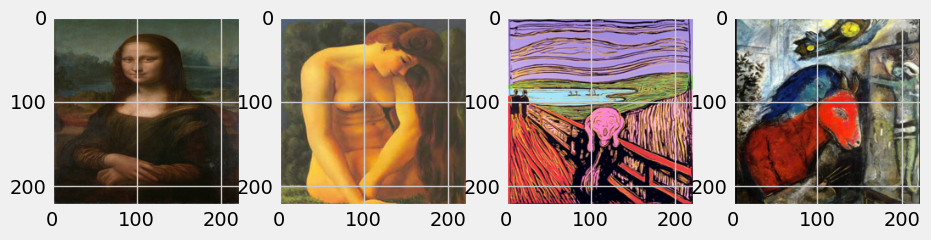

In [80]:
from PIL import Image

test1 = Image.open(
    './test_data/Mona_Lisa,_by_Leonardo_da_Vinci,_from_C2RMF_natural_color.jpg')
test2 = Image.open(
    './test_data/nude-seated-on-the-grass-1950(1).jpg')
test3 = Image.open(
    './test_data/warhol_scream_large.jpg')
test4 = Image.open(
    './test_data/Marc_chagall-self_portrait_with_a_clock_in_front_of_crucifixion.jpg')
test1_resize = test1.resize((224, 224))
test2_resize = test2.resize((224, 224))
test3_resize = test3.resize((224, 224))
test4_resize = test4.resize((224, 224))
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(10, 5))
axes[0].imshow(test1_resize, cmap='gray')
axes[1].imshow(test2_resize, cmap='gray')
axes[2].imshow(test3_resize, cmap='gray')
axes[3].imshow(test4_resize, cmap='gray')


In [81]:
model_cnngcn.eval()
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

def prediction(img):
	img_tensor = transform(img)
	img_tensor = img_tensor.unsqueeze(0).to(device)

	output = model_cnngcn(img_tensor)
	prediction = torch.sigmoid(output) >= 0.5

	result = []
	for index, value in enumerate(prediction):
			if value == 1:
					result.append(total_labels[index])

	print(result)

prediction(test1_resize)
prediction(test2_resize)
prediction(test3_resize)
prediction(test3_resize)


['oil', 'canvas', 'portrait']
['oil', 'canvas', 'expressionism', 'portrait']
['oil']
['oil']
